In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)

## Этап 1. Генерация изображений.

Последовательность выполнения генерации следующая:
- создание, аугментация и ресайз случайного заднего фона изображения из 'static/backgrounds`;
- генерация триплетов `image`, `character_heatmap` и `affinity_heatmap` в которой используются случайные значения `color`, `font`, `text`, `opacity` и `size`, значения которых задаются в `static/constants.py`;
- изменение размеров триплетов и размещение их на background.

При генерации триплетов image, character_heatmap и affinity_heatmap используются случайные `background`, `color`, `font`, `text`, размещённые в `static`, и значения `opacity` и `size`.


Код генерации триплетов приведён в `utils.py`, а генерация общего изображения в `generate_image.py`.

In [362]:
import matplotlib.pyplot as plt

from generate_utils import generate_random_image, save_image_and_mask
from static.constants import backgrounds, colors, fonts, texts, opacities, sizes

In [751]:
%%time
image, heatmap = generate_random_image(
    fonts=fonts, 
    texts=texts, 
    colors=colors, 
    backgrounds=backgrounds, 
    opacities=opacities, 
    sizes=sizes)

CPU times: total: 391 ms
Wall time: 169 ms


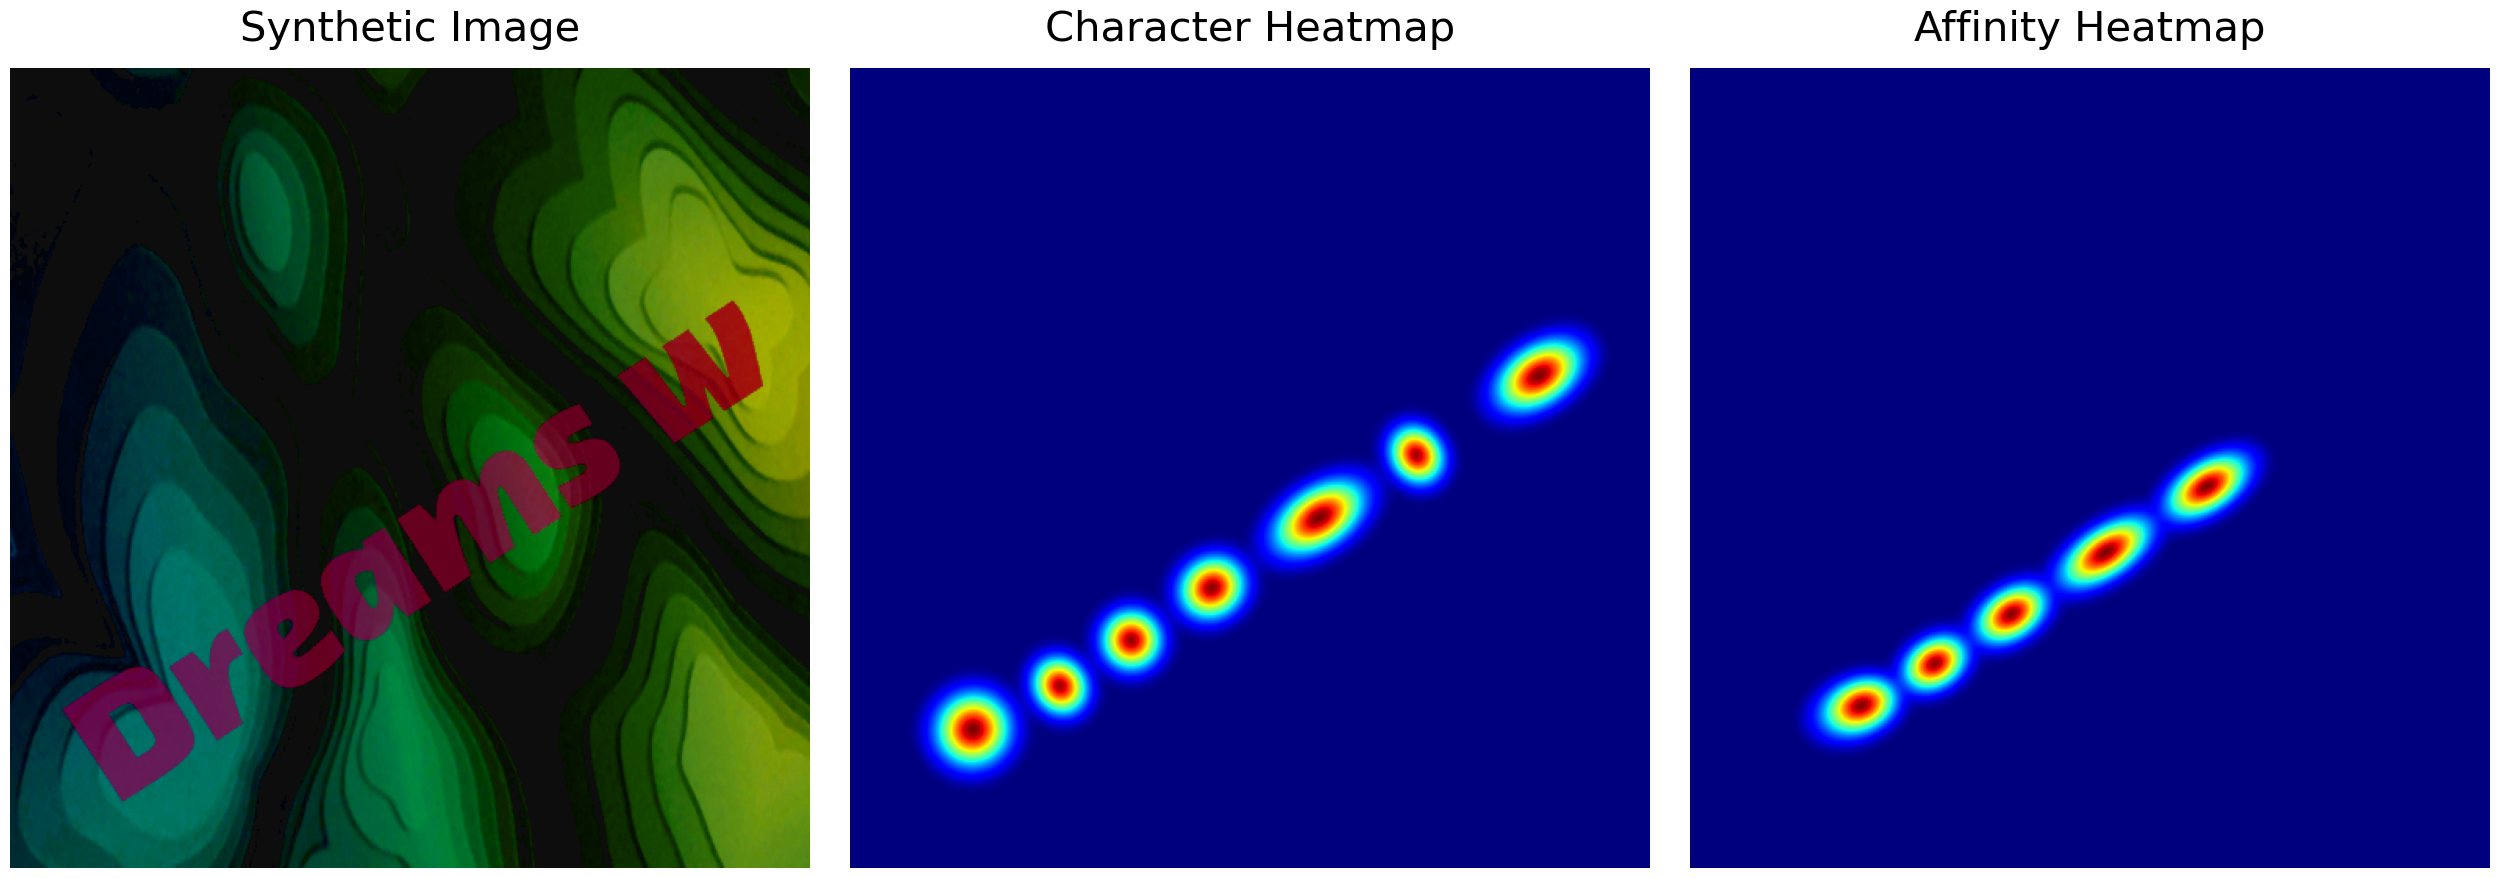

In [747]:
fig, ax = plt.subplots(1, 3, figsize=(32, 32))

for i, title in enumerate(["Synthetic Image", "Character Heatmap", "Affinity Heatmap"]):
    ax[i].imshow(image if i == 0 else heatmap[..., i-1], cmap='jet' if i > 0 else None)
    ax[i].axis("off")  
    ax[i].set_title(title, fontsize=30, pad=20)  

plt.subplots_adjust(wspace=0.05)
plt.show()

Для сохранения изображения и масок используется функция `save_image_and_mask`.

In [ ]:
save_image_and_mask(
    idx=999,
    image=image,
    heatmap=heatmap,
    images_folder='testing',
    char_masks_folder='testing',
    aff_mask_folder='testing',
)

Для генерирования датасета используется `parallel_generate_images.py`, который ускоряет генерирование и сохранение изображений за счёт многопоточности.

In [45]:
!python generate_images.py --help

usage: generate_images.py [-h] [--num_images NUM_IMAGES]
                          [--chunk_size CHUNK_SIZE]
                          [--num_workers NUM_WORKERS]
                          [--save_folder SAVE_FOLDER]
                          [--show_steps SHOW_STEPS]

Скрипт для создания и сохранения случайных изображений с использованием
многопоточности. Выполнение функций скрипта происходит в двух созависимых
pool-ах: генерации и сохранения. Т.е. генерация следующего chunk_size
количества изображений начнётся только после их сохранения на диск. Это
позволяет не заполнять оперативную память изображениями, которые ещё не успели
сохраниться на диск.

options:
  -h, --help            show this help message and exit
  --num_images NUM_IMAGES
                        Количество генерируемых изображений. По умолчанию:
                        5000
  --chunk_size CHUNK_SIZE
                        Размер порции генерируемых изображений. По умолчанию:
                        100
  --num_worker

In [ ]:
!python generate_images.py --num_images 5000 --save_folder C:\datasets\syntdata

## Этап 2. Дообучение SegFormer на синтетических данных

Последовательность дообучения следующая:
1. Создание модели с на основе предобученной модели сегментации `segformer-b0`;
2. Формирование train/test датасетов синтетичесих данных с кешированием объектов в оперативную память для ускорения циклов обучения;
3. Подбор гиперпараметров обучения модели и запуск процесса обучения с рассчётом метрик.

### 2.1 Создание модели

В качестве предобученного `SegFormer` будет использоваться `nvidia/segformer-b0-finetuned-ade-512-512`.  
В качестве loss-функции будет использоваться `MSELoss`.

In [36]:
import torch
from torch.nn import MSELoss

from train_utils import SegformerForСraft, seed_everything
from transformers import SegformerImageProcessor

In [38]:
seed_everything(seed=37)
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"

feature_extractor = SegformerImageProcessor.from_pretrained(model_name)
model = SegformerForСraft.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True, loss_fn=MSELoss())

Some weights of SegformerForСraft were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Создание датасета

Формирование датасета выполняется из `pd.DataFrame` ссылок на image, character_mask и affinity_mask. Для ускорения итерирования по датасетам, а следовательно и ускорения обучения, выполняется кеширование данных в оперативную память.

In [9]:
from sklearn.model_selection import train_test_split
from train_utils import CRAFTDataset, craft_data_collator, collect_data

In [11]:
dataset = collect_data(r'C:\datasets\syntdata')

train, test = train_test_split(dataset, test_size=0.2, random_state=37)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

train_dataset = CRAFTDataset(feature_extractor, train, caching=True)
test_dataset = CRAFTDataset(feature_extractor, test, caching=True)

### Обучение

После каждой эпохи обучения проводится валидация с рассчётом метрик на тестовой части датасета с помощью функции `compute_metric`. 
  
Для каждого примера из тестовой части датасета вычисляются координаты bbox-ов текстов на изображении по выходам модели и ground_truth. Для ускорения этого процесса применено параллельное вычисление функции `craft_utils.getDetBoxes()`.  

На основании этих bbox-ов выполняется рассчёт метрик `IoU`, `F1-Score`, `Presicion` и `Recall`.

In [40]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from train_utils import compute_metrics, inference_sample, save_training_results

In [42]:
training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",  
    save_strategy="epoch",        
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_accumulation_steps=50,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    load_best_model_at_end=True

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=craft_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=5,
        early_stopping_threshold=0.0
    )]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Mean Iou,F1,Precision,Recall
1,0.005900,0.004171,0.732535,0.309181,0.301115,0.317690
2,0.004000,0.003142,0.758011,0.428446,0.429523,0.427374
3,0.003400,0.002681,0.786483,0.587787,0.602872,0.573438
4,0.003000,0.002257,0.779058,0.611557,0.638464,0.586827
5,0.002300,0.001955,0.797452,0.683914,0.714223,0.656072
6,0.002000,0.001799,0.802098,0.736923,0.764048,0.711658
7,0.001700,0.001724,0.802136,0.785754,0.817451,0.756424
8,0.001900,0.001628,0.800949,0.778766,0.814530,0.746010
9,0.001600,0.001468,0.810455,0.787874,0.829199,0.750473
10,0.001600,0.001441,0.812746,0.834849,0.844377,0.825534


TrainOutput(global_step=15000, training_loss=0.002652845346927643, metrics={'train_runtime': 1331.3955, 'train_samples_per_second': 300.437, 'train_steps_per_second': 75.109, 'total_flos': 1.05167733129216e+18, 'train_loss': 0.002652845346927643, 'epoch': 15.0})

In [215]:
import pandas as pd

def save_training_results(trainer, save_dir):
    log_history = trainer.state.log_history
    df = pd.DataFrame(log_history)

    plt.subplots(1, 2, figsize=(16, 5))
    plt.subplot(1, 2, 1)

    train_loss = df[df["loss"].notna()]
    plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss", marker="o")

    val_loss = df[df["eval_loss"].notna()]
    plt.plot(val_loss["step"], val_loss["eval_loss"], label="Validation Loss", marker="o")

    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    for metric in ["eval_mean_iou", "eval_f1", "eval_precision", "eval_recall"]:
        plt.plot(df[df[metric].notna()]['step'], df[metric].dropna(), label=metric, marker="o")

    plt.xlabel("Training Steps")
    plt.ylabel("Metric Value")
    plt.title("Evaluation Metrics Over Time")
    plt.legend()
    plt.grid()

    plt.savefig(os.path.join(save_dir, 'training_plots.png'), bbox_inches='tight', pad_inches=0.1)
    df.to_csv(os.path.join(save_dir, 'training_log.csv'), index=False)

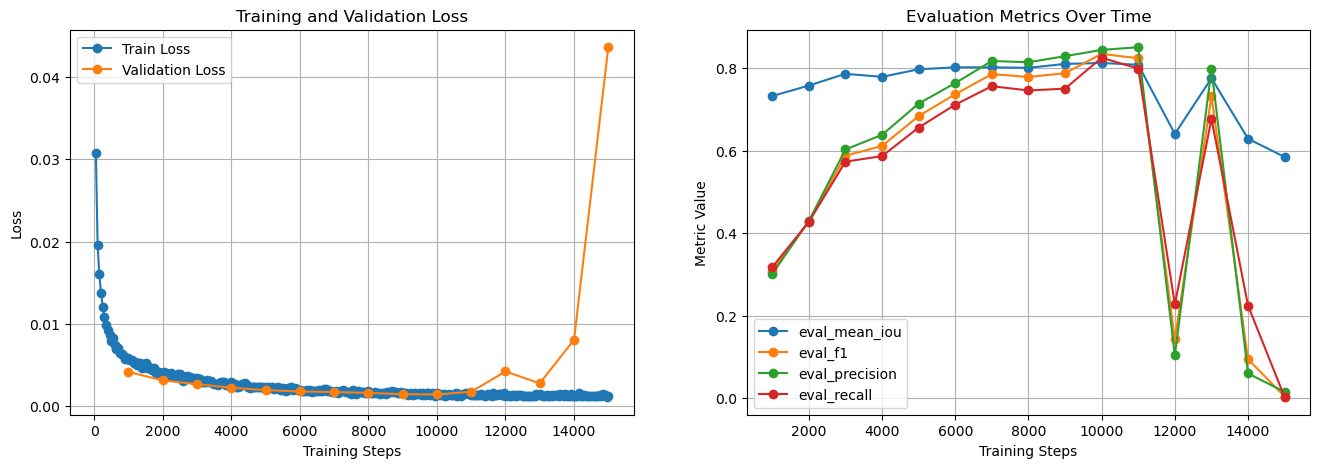

In [217]:
save_training_results(trainer, './checkpoints')

Finetuning модели можно выполнить запустив скрипт `train.py`

In [33]:
!python train.py --help

usage: train.py [-h] [--input_dir INPUT_DIR] [--output_dir OUTPUT_DIR]
                [--model_name MODEL_NAME]
                [--num_train_epochs NUM_TRAIN_EPOCHS]
                [--batch_size BATCH_SIZE] [--learning_rate LEARNING_RATE]
                [--weight_decay WEIGHT_DECAY] [--test_size TEST_SIZE]
                [--caching CACHING]

Скрипт для finetuning предобученной сегментационной модели на синтетических
данных

options:
  -h, --help            show this help message and exit
  --input_dir INPUT_DIR
                        Директория с синтетическими изображениями
  --output_dir OUTPUT_DIR
                        Директория сохранения результатов обучения
  --model_name MODEL_NAME
                        Имя предобученной модели
  --num_train_epochs NUM_TRAIN_EPOCHS
                        Количество эпох обучения
  --batch_size BATCH_SIZE
                        Размер батча
  --learning_rate LEARNING_RATE
  --weight_decay WEIGHT_DECAY
  --test_size TEST_SIZE
         

In [53]:
!python train.py --input_dir dataset --output_dir checkpoits_test --num_train_epochs 10 --caching True

^C


Пример инференса на тестовой части датасета

In [46]:
import os
import random
import matplotlib.pyplot as plt

from PIL import Image

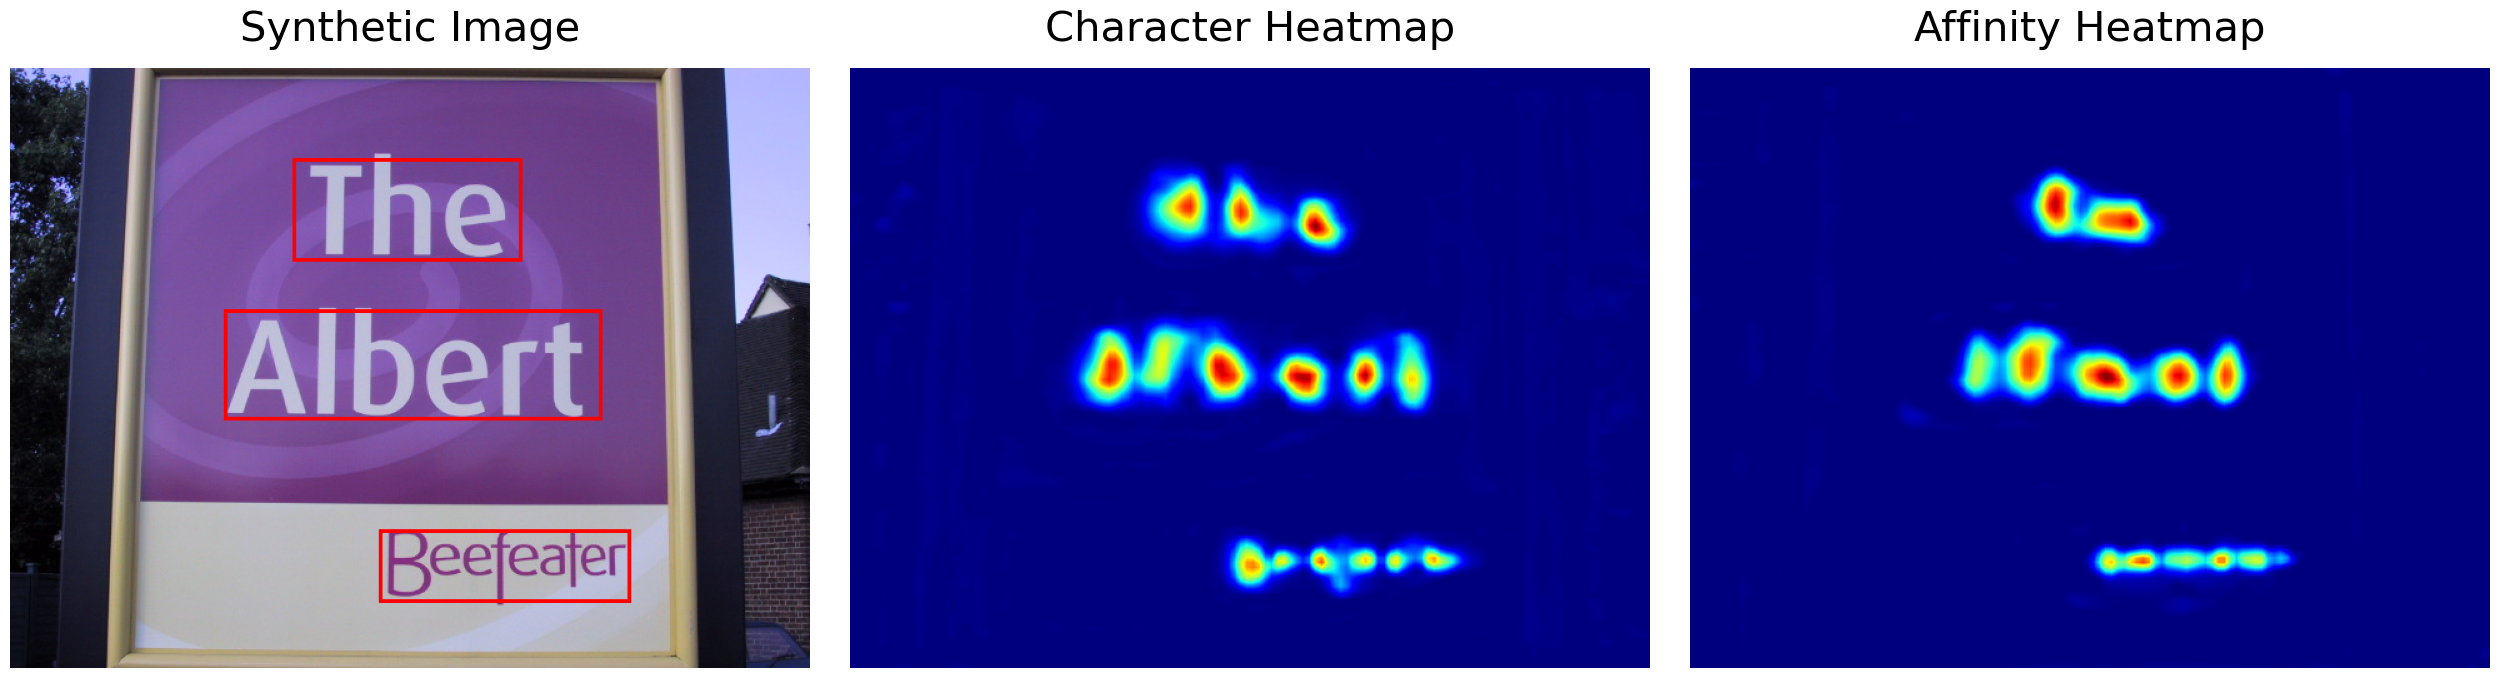

In [178]:
validation_path = os.path.abspath('validation_data/images')

image = random.choice(os.listdir('validation_data/images/'))
image = Image.open(os.path.join(validation_path, image)).convert('RGB')

image, boxes_pred, heatmaps = inference_sample(model, feature_extractor, image, 0.1, 0.1, 0.1)

fig, ax = plt.subplots(1, 3, figsize=(32, 10))

for i, title in enumerate(["Synthetic Image", "Character Heatmap", "Affinity Heatmap"]):
    ax[i].imshow(image if i == 0 else heatmaps[i-1], cmap='jet' if i > 0 else None) 
    ax[i].set_title(title, fontsize=30, pad=20)  
    ax[i].axis("off")   

plt.subplots_adjust(wspace=0.05)
plt.savefig('static/example_inference.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Этап 3. Настройка гиперпараметров для CRAFT и оценка на реальных данных

На этом этапе выполнена настройка гиперпараметров CRAFT, для получаения максимальных значений метрик IoU и F1-Score на тестовой части датасета. В Качестве оптимизатора используется `optuna`, а в качестве оптимизируемых параметров аргументы функции **`craft_utils.getDetBoxes`**, а именно `text_threshold`, `link_threshold` и `low_text`.

Также проведена оценка работы алгоритма на реальных данных и сипользованием оптимизированных параметров.

In [204]:
import torch
import optuna

from IPython.display import clear_output

Сбор предсказаний модели на тестовом датасете.

In [206]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

prediction_heatmaps, ground_truth_heatmaps = [], []
batch_size = 4

model.eval()
model.to(device)
for idx in range(len(test_dataset) // batch_size):
    batch = test_dataset[idx * batch_size : idx * batch_size + batch_size]

    batch['labels'] = batch['labels'].to(device)
    batch['pixel_values'] = batch['pixel_values'].to(device)
    
    with torch.no_grad():
        outputs = model(**batch)

        prediction = outputs['logits']
        ground_truth = batch['labels']

        prediction_heatmaps.append(prediction)
        ground_truth_heatmaps.append(ground_truth)

prediction_heatmaps_ = torch.concat(prediction_heatmaps).cpu().detach().numpy()
ground_truth_heatmaps = torch.concat(ground_truth_heatmaps).cpu().detach().numpy()

Опеределим целевую функцию, которую будем максимизировать

In [209]:
def objective(trial):
    tt = trial.suggest_float('tt', 0.0, 1.0)
    lt = trial.suggest_float('lt', 0.0, 1.0)
    lwt = trial.suggest_float('lwt', 0.0, 1.0)
    
    metrics = compute_metrics((prediction_heatmaps_, ground_truth_heatmaps), tt=tt, lt=lt, lwt=lwt)
    score = (metrics['mean_iou'] + metrics['f1']) / 2.0
    return score  

In [213]:
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)
clear_output()

print('Best Score:', study.best_value)
print('Best trial:', study.best_trial.number)
print('Best params:', study.best_params)

Best Score: 0.882084783776603
Best trial: 47
Best params: {'tt': 0.28317025163382853, 'lt': 0.11569481573554656, 'lwt': 0.20711807874550547}


## Этап 4. Валидация на реальных объектах.

На этом этапе выполним валидацию модели на реальных объектах. Для этого будем использовать изображения и аннтоцации к ним из директории `validation_data`

In [258]:
from train_utils import calculate_metric

In [260]:
with open('validation_data/annotations.json', 'r') as file:
    images = [Image.open(os.path.join(validation_path, image)) for image in sorted(os.listdir(validation_path))]
    gt_bboxes_list = json.load(file)          

In [262]:
pred_bboxes_list = [inference_sample(model, feature_extractor, image, **study.best_params)[1] for image in images]
gt_bboxes_list = [gt_bboxes_list[key] for key in sorted(gt_bboxes_list)]

In [288]:
results = calculate_metric(pred_bboxes_list, gt_bboxes_list)
results = pd.DataFrame(results, index=[0])
results.columns=['Mean_IoU', 'F1-Score', 'Precision', 'Recall']

print(round(results, 4).to_markdown(index=False))

|   Mean_IoU |   F1-Score |   Precision |   Recall |
|-----------:|-----------:|------------:|---------:|
|     0.7954 |     0.5098 |      0.4974 |   0.5228 |


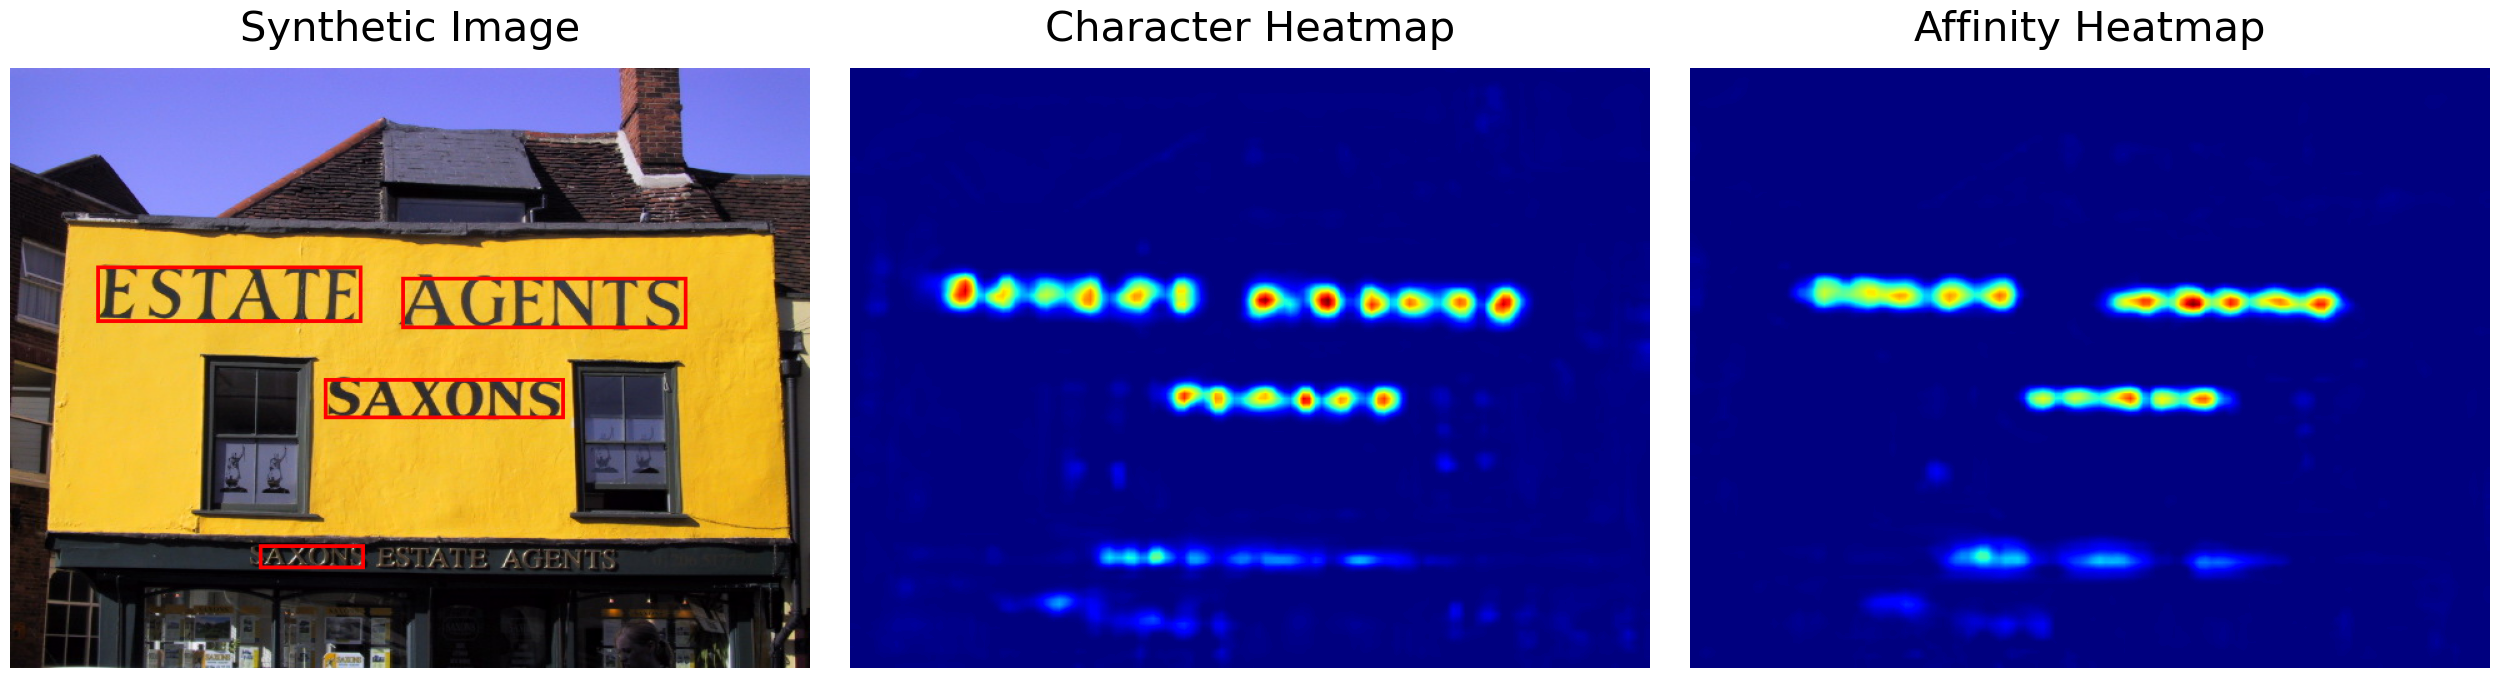

In [273]:
image, boxes_pred, heatmaps = inference_sample(model, feature_extractor, images[42], **study.best_params)

fig, ax = plt.subplots(1, 3, figsize=(32, 10))

for i, title in enumerate(["Synthetic Image", "Character Heatmap", "Affinity Heatmap"]):
    ax[i].imshow(image if i == 0 else heatmaps[i-1], cmap='jet' if i > 0 else None) 
    ax[i].set_title(title, fontsize=30, pad=20)  
    ax[i].axis("off")   

plt.subplots_adjust(wspace=0.05)
plt.show()